# Temporary development-only visualiser
---
This script is <b>NOT</b> a part of the PPD library.
<br>
It is used for exploratory plotting during development.

Optional dependency: matplotlib

In [21]:
import json
import sqlite3
import math
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt

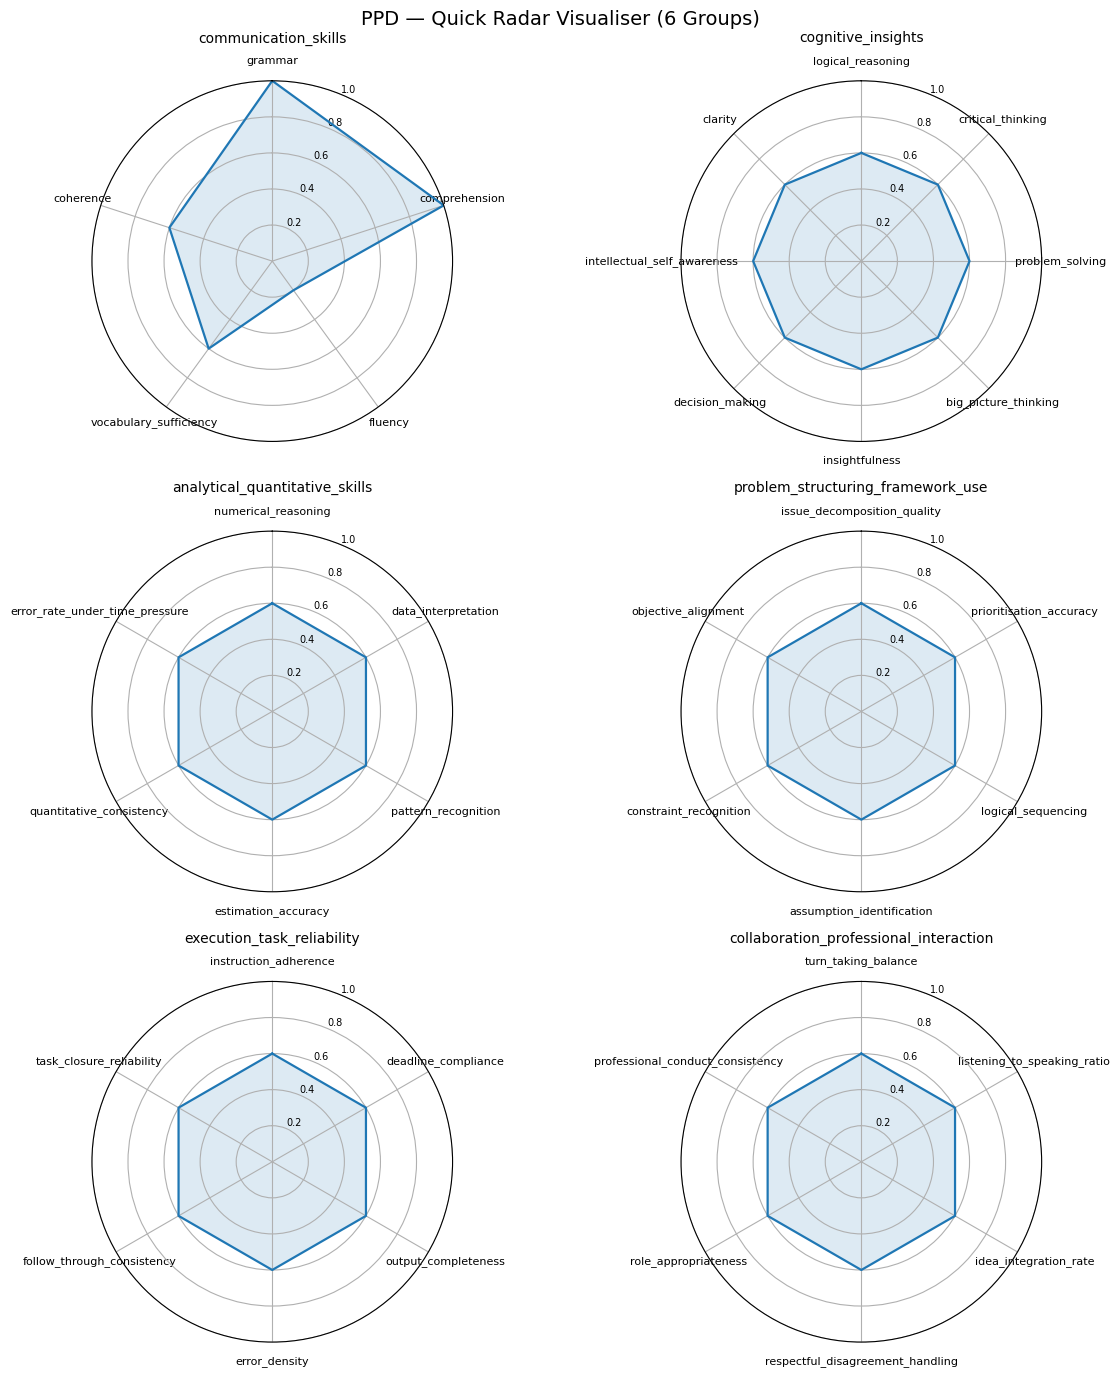

In [22]:
# ------------------------------------------------------------
# Quick temporary PPD visualiser (3x2 radar grid)
# - Loads: examples/input_json_set_1/balanced_uniform_high.json
# - Plots: 6 groups (one radar per group)
# ------------------------------------------------------------

# HERE = Path(__file__).resolve().parent
INPUT_PATH = Path("input/individual_tests/polarised_group.json")


def _load_candidate_json(path: Path) -> dict:
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)


def _radar(ax, labels, values, title: str):
    # values assumed already normalized to [0, 1]
    n = len(labels)
    angles = [2 * math.pi * i / n for i in range(n)]
    angles += angles[:1]  # close loop

    vals = list(values) + [values[0]]

    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=8)

    ax.set_ylim(0.0, 1.0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=7)

    ax.plot(angles, vals, linewidth=1.6)
    ax.fill(angles, vals, alpha=0.15)

    ax.set_title(title, fontsize=10, pad=10)


def main():
    payload = _load_candidate_json(INPUT_PATH)
    scores = payload["scores"]

    # Expecting exactly these 6 groups (as per your framework)
    groups_order = [
        "communication_skills",
        "cognitive_insights",
        "analytical_quantitative_skills",
        "problem_structuring_framework_use",
        "execution_task_reliability",
        "collaboration_professional_interaction",
    ]

    fig, axes = plt.subplots(
        nrows=3, ncols=2, subplot_kw={"projection": "polar"}, figsize=(12, 14)
    )
    axes = axes.flatten()

    for i, group in enumerate(groups_order):
        ax = axes[i]
        group_scores = scores[group]

        labels = list(group_scores.keys())
        raw_vals = [float(group_scores[k]) for k in labels]

        # Normalize 1–5 scale -> [0, 1]
        vals = [v / 5.0 for v in raw_vals]

        _radar(ax, labels, vals, title=group)

    fig.suptitle("PPD — Quick Radar Visualiser (6 Groups)", fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


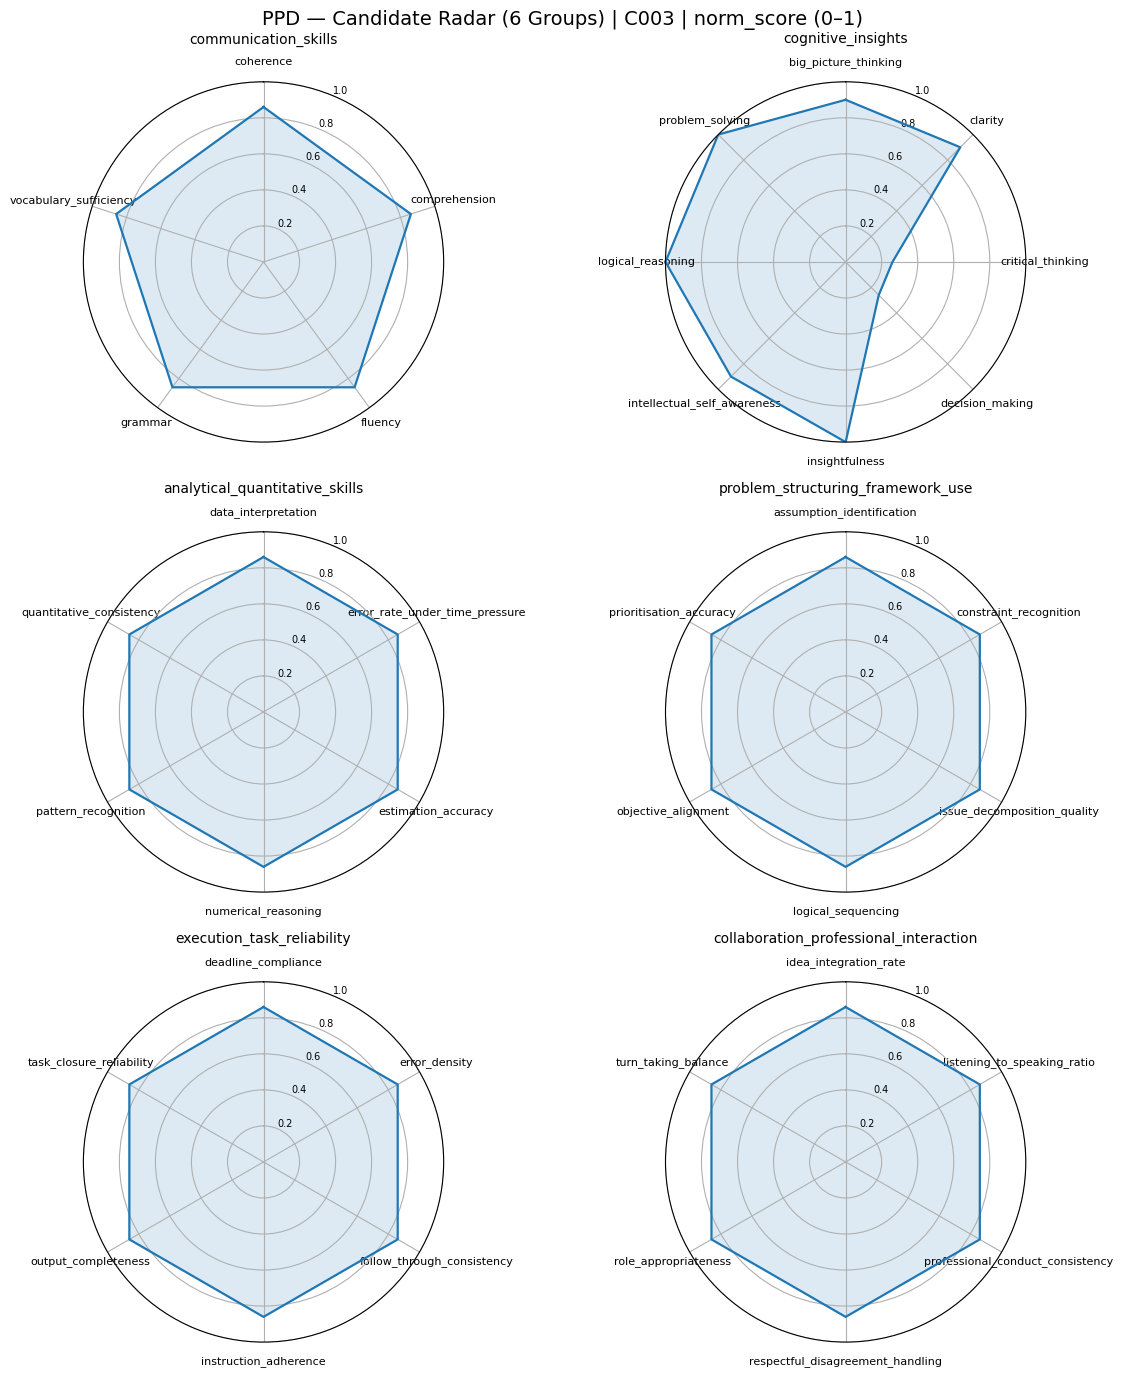

In [28]:
# Same visualiser but loading from SQLite DB
# ---- Config ----
# HERE = Path(__file__).resolve().parent
DB_PATH = Path("output/cohort_diverse_final.db")     # <-- point to your .db
CANDIDATE_ID = "C003"                               # <-- choose candidate here
USE_NORM = True                                     # True -> norm_score, False -> raw_score (will be /5.0)

GROUPS_ORDER = [
    "communication_skills",
    "cognitive_insights",
    "analytical_quantitative_skills",
    "problem_structuring_framework_use",
    "execution_task_reliability",
    "collaboration_professional_interaction",
]


def _radar(ax, labels, values, title: str):
    # values assumed already normalized to [0, 1]
    n = len(labels)
    angles = [2 * math.pi * i / n for i in range(n)]
    angles += angles[:1]  # close loop
    vals = list(values) + [values[0]]

    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=8)

    ax.set_ylim(0.0, 1.0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=7)

    ax.plot(angles, vals, linewidth=1.6)
    ax.fill(angles, vals, alpha=0.15)

    ax.set_title(title, fontsize=10, pad=10)


def _fetch_candidate_scores(db_path: Path, candidate_id: str, use_norm: bool) -> dict:
    """
    Returns:
      {
        "communication_skills": {"grammar": 0.82, ...},
        ...
      }
    Values returned are NORMALISED to [0,1] regardless of use_norm flag.
    """
    if not db_path.exists():
        raise FileNotFoundError(f"DB not found: {db_path}")

    conn = sqlite3.connect(str(db_path))
    conn.row_factory = sqlite3.Row
    try:
        # Verify candidate exists
        cur = conn.execute(
            "SELECT 1 FROM candidates WHERE candidate_id = ? LIMIT 1",
            (candidate_id,),
        )
        if cur.fetchone() is None:
            raise ValueError(f"candidate_id not found: {candidate_id}")

        score_col = "norm_score" if use_norm else "raw_score"

        rows = conn.execute(
            f"""
            SELECT
              d.group_key,
              d.dimension_name,
              s.{score_col} AS score
            FROM scores s
            JOIN dimensions d
              ON d.dimension_key = s.dimension_key
            WHERE s.candidate_id = ?
            ORDER BY d.group_key, d.dimension_name
            """,
            (candidate_id,),
        ).fetchall()

        out: dict[str, dict[str, float]] = {g: {} for g in GROUPS_ORDER}
        for r in rows:
            g = r["group_key"]
            dim = r["dimension_name"]
            val = float(r["score"])

            # Ensure normalized to [0,1] no matter what
            if not use_norm:
                val = val / 5.0

            # Clamp just in case
            val = max(0.0, min(1.0, val))

            if g not in out:
                out[g] = {}
            out[g][dim] = val

        return out
    finally:
        conn.close()


def main():
    scores_by_group = _fetch_candidate_scores(DB_PATH, CANDIDATE_ID, USE_NORM)

    fig, axes = plt.subplots(
        nrows=3, ncols=2, subplot_kw={"projection": "polar"}, figsize=(12, 14)
    )
    axes = axes.flatten()

    for i, group in enumerate(GROUPS_ORDER):
        ax = axes[i]
        group_scores = scores_by_group.get(group, {})

        if not group_scores:
            # If something is missing, still show an empty plot
            ax.set_title(f"{group} (no data)", fontsize=10, pad=10)
            ax.set_ylim(0.0, 1.0)
            continue

        # Keep a stable order for readability
        labels = sorted(group_scores.keys())
        vals = [group_scores[k] for k in labels]

        _radar(ax, labels, vals, title=group)

    mode = "norm_score (0–1)" if USE_NORM else "raw_score/5 (0–1)"
    fig.suptitle(
        f"PPD — Candidate Radar (6 Groups) | {CANDIDATE_ID} | {mode}",
        fontsize=14,
        y=0.98,
    )
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

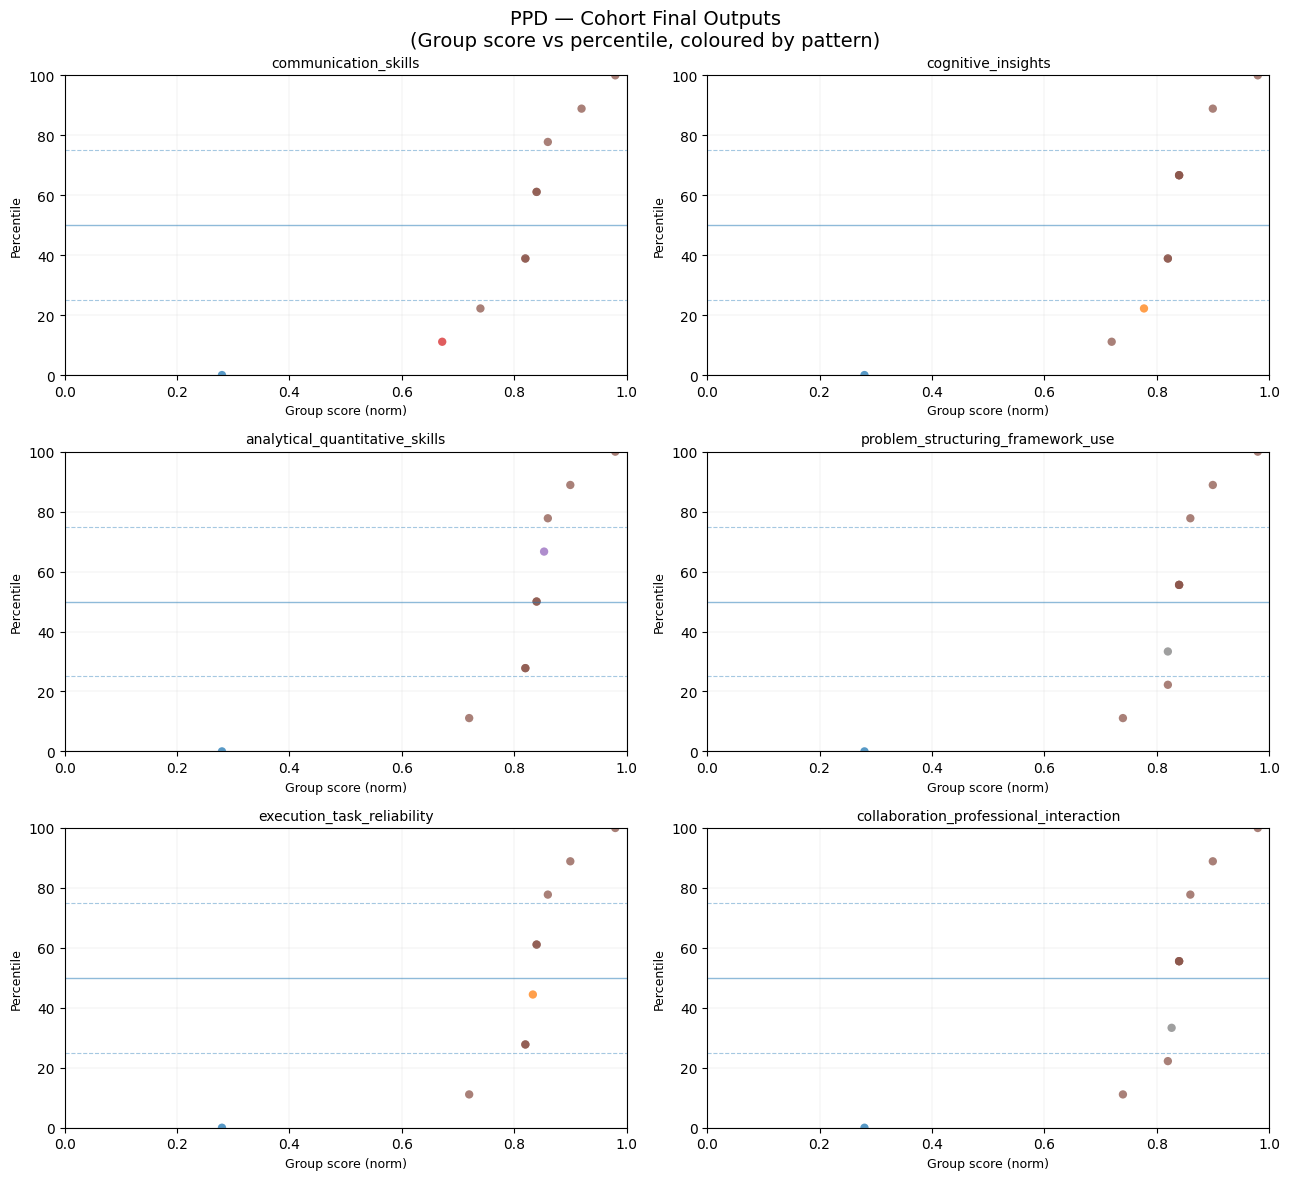

In [35]:
# ---- Config ----
DB_PATH = Path("output/cohort_diverse_final.db")   # <-- FINAL materialised DB

GROUPS_ORDER = [
    "communication_skills",
    "cognitive_insights",
    "analytical_quantitative_skills",
    "problem_structuring_framework_use",
    "execution_task_reliability",
    "collaboration_professional_interaction",
]

PATTERN_COLOURS = {
    "balanced": "#2ca02c",
    "bottlenecked": "#d62728",
    "polarised": "#ff7f0e",
    "noisy": "#9467bd",
    "uniform_low": "#1f77b4",
    "uniform_high": "#8c564b",
    "other": "#7f7f7f",
}


# ------------------------------------------------------------
# data fetch
# ------------------------------------------------------------

def _fetch_group_level_outputs(db_path: Path):
    """
    Returns per-group plotting data derived ONLY from cohort tables.
    """
    conn = sqlite3.connect(str(db_path))
    conn.row_factory = sqlite3.Row

    try:
        # Candidate group scores + percentiles
        rows = conn.execute(
            """
            SELECT
              s.candidate_id,
              s.group_key,
              s.group_score_norm,
              p.percentile_rank
            FROM cohort_candidate_group_scores s
            JOIN cohort_candidate_group_percentiles p
              ON p.candidate_id = s.candidate_id
             AND p.group_key = s.group_key
            """
        ).fetchall()

        # Pattern labels per candidate/group
        pattern_rows = conn.execute(
            """
            SELECT
              candidate_id,
              group_key,
              balanced, bottlenecked, polarised,
              noisy, uniform_low, uniform_high
            FROM candidate_group_patterns
            """
        ).fetchall()

        # Group summary percentiles
        summary_rows = conn.execute(
            """
            SELECT
              group_key, p25, p50, p75
            FROM cohort_group_summary
            """
        ).fetchall()

        # ---- index helpers ----
        patterns = {}
        for r in pattern_rows:
            if r["bottlenecked"]:
                lab = "bottlenecked"
            elif r["polarised"]:
                lab = "polarised"
            elif r["noisy"]:
                lab = "noisy"
            elif r["uniform_low"]:
                lab = "uniform_low"
            elif r["uniform_high"]:
                lab = "uniform_high"
            elif r["balanced"]:
                lab = "balanced"
            else:
                lab = "other"
            patterns[(r["candidate_id"], r["group_key"])] = lab

        summaries = {
            r["group_key"]: (r["p25"], r["p50"], r["p75"])
            for r in summary_rows
        }

        out = {g: {"x": [], "y": [], "c": []} for g in GROUPS_ORDER}

        for r in rows:
            g = r["group_key"]
            cid = r["candidate_id"]

            if g not in out:
                continue

            out[g]["x"].append(r["group_score_norm"])
            out[g]["y"].append(r["percentile_rank"])
            lab = patterns.get((cid, g), "other")
            out[g]["c"].append(PATTERN_COLOURS.get(lab, "#7f7f7f"))

        return out, summaries

    finally:
        conn.close()


# ------------------------------------------------------------
# plotting
# ------------------------------------------------------------

def main():
    data, summaries = _fetch_group_level_outputs(DB_PATH)

    fig, axes = plt.subplots(3, 2, figsize=(13, 12))
    axes = axes.flatten()

    for i, group in enumerate(GROUPS_ORDER):
        ax = axes[i]
        gdat = data.get(group)

        if not gdat or not gdat["x"]:
            ax.set_title(f"{group} (no data)", fontsize=10)
            ax.axis("off")
            continue

        ax.scatter(
            gdat["x"],
            gdat["y"],
            c=gdat["c"],
            alpha=0.75,
            edgecolors="none",
        )

        ax.set_xlim(0.0, 1.0)
        ax.set_ylim(0.0, 100.0)

        ax.set_xlabel("Group score (norm)", fontsize=9)
        ax.set_ylabel("Percentile", fontsize=9)
        ax.set_title(group, fontsize=10)

        # cohort percentile reference lines
        p25, p50, p75 = summaries.get(group, (None, None, None))
        if p25 is not None:
            ax.axhline(25, linestyle="--", linewidth=0.8, alpha=0.4)
            ax.axhline(50, linestyle="-", linewidth=1.0, alpha=0.5)
            ax.axhline(75, linestyle="--", linewidth=0.8, alpha=0.4)

        ax.grid(True, linewidth=0.3, alpha=0.4)

    fig.suptitle(
        "PPD — Cohort Final Outputs\n(Group score vs percentile, coloured by pattern)",
        fontsize=14,
        y=0.98,
    )

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

# Attempting Pseudo Interactive Web Visualisation

In [47]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# ------------------------------------------------------------
# Config
# ------------------------------------------------------------

DB_PATH = Path("output/cohort_diverse_final.db")

GROUPS_ORDER = [
    "communication_skills",
    "cognitive_insights",
    "analytical_quantitative_skills",
    "problem_structuring_framework_use",
    "execution_task_reliability",
    "collaboration_professional_interaction",
]

PATTERN_COLOURS = {
    "balanced": "#2ca02c",
    "bottlenecked": "#d62728",
    "polarised": "#ff7f0e",
    "noisy": "#9467bd",
    "uniform_low": "#1f77b4",
    "uniform_high": "#8c564b",
    "other": "#7f7f7f",
}


# ------------------------------------------------------------
# Load data (FINAL cohort tables only)
# ------------------------------------------------------------

def load_data():
    if not DB_PATH.exists():
        raise FileNotFoundError(DB_PATH)

    conn = sqlite3.connect(str(DB_PATH))
    try:
        df = pd.read_sql_query(
            """
            SELECT
              s.candidate_id,
              s.group_key,
              s.group_score_norm,
              p.percentile_rank
            FROM cohort_candidate_group_scores s
            JOIN cohort_candidate_group_percentiles p
              ON p.candidate_id = s.candidate_id
             AND p.group_key = s.group_key
            """,
            conn,
        )

        pat = pd.read_sql_query(
            """
            SELECT
              candidate_id,
              group_key,
              balanced, bottlenecked, polarised,
              noisy, uniform_low, uniform_high
            FROM candidate_group_patterns
            """,
            conn,
        )

        summary = pd.read_sql_query(
            """
            SELECT group_key, p25, p50, p75
            FROM cohort_group_summary
            """,
            conn,
        )

        def label_row(r):
            if r["bottlenecked"]:
                return "bottlenecked"
            if r["polarised"]:
                return "polarised"
            if r["noisy"]:
                return "noisy"
            if r["uniform_low"]:
                return "uniform_low"
            if r["uniform_high"]:
                return "uniform_high"
            if r["balanced"]:
                return "balanced"
            return "other"

        pat["pattern_label"] = pat.apply(label_row, axis=1)

        df = df.merge(
            pat[["candidate_id", "group_key", "pattern_label"]],
            on=["candidate_id", "group_key"],
            how="left",
        )
        df["pattern_label"] = df["pattern_label"].fillna("other")

        summaries = {
            r["group_key"]: (r["p25"], r["p50"], r["p75"])
            for _, r in summary.iterrows()
        }

        return df, summaries

    finally:
        conn.close()


# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------

def main():
    df, summaries = load_data()

    fig = make_subplots(
        rows=3,
        cols=2,
        subplot_titles=GROUPS_ORDER,
        horizontal_spacing=0.08,
        vertical_spacing=0.10,
    )

    for i, group in enumerate(GROUPS_ORDER):
        r = i // 2 + 1
        c = i % 2 + 1

        dfg = df[df["group_key"] == group]
        if dfg.empty:
            continue

        for pattern, color in PATTERN_COLOURS.items():
            dff = dfg[dfg["pattern_label"] == pattern]
            if dff.empty:
                continue

            fig.add_trace(
                go.Scatter(
                    x=dff["group_score_norm"],
                    y=dff["percentile_rank"],
                    mode="markers",
                    marker=dict(color=color, size=8, opacity=0.75),
                    name=pattern,
                    legendgroup=pattern,
                    showlegend=(i == 0),
                    text=dff["candidate_id"],
                    hovertemplate=(
                        "candidate: %{text}<br>"
                        "group score: %{x:.3f}<br>"
                        "percentile: %{y:.1f}<extra></extra>"
                    ),
                ),
                row=r,
                col=c,
            )

        # percentile reference lines
        if group in summaries:
            for y in (25, 50, 75):
                fig.add_hline(
                    y=y,
                    line_dash="dash" if y != 50 else "solid",
                    opacity=0.35,
                    row=r,
                    col=c,
                )

        fig.update_xaxes(range=[0, 1], row=r, col=c)
        fig.update_yaxes(range=[0, 100], row=r, col=c)

    fig.update_layout(
        title="PPD — Cohort Final Outputs (Interactive)",
        legend_title_text="Pattern label",
        height=900,
    )

    # Write interactive HTML
    out = "output/ppd_cohort_scatter.html"
    fig.write_html(out, auto_open=True)

    print(f"Saved interactive plot to: {out}")


if __name__ == "__main__":
    main()


Saved interactive plot to: output/ppd_cohort_scatter.html
